# Fine-tune a YOLOv8 detection model

This notebook will train a [Yolov8](https://github.com/ultralytics/ultralytics) model for tank detection using publicly available annotated images of tanks.

As the notebook will run the training with `PyTorch`, it is recommended to have GPUs available. If running in Google Colab, go to Edit > Notebook settings and select GPU hardware acceleration.

This notebook expects that the dataset created in the notebook [01_Dataset](./01_Dataset.ipynb) has been saved to disk.

### Setup

To start, check GPU support.

In [9]:
import torch

print(f"Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

Setup complete. Using torch 2.3.1+cu121 (NVIDIA RTX A6000)


### Load dataset

We'll first load the dataset created on disk.

In [10]:
from pathlib import Path

dataset_dir = Path() / "dataset"

In [11]:
import fiftyone as fo

# The splits to load
splits = ["train", "val", "test"]

# Load the dataset, using tags to mark the samples in each split
dataset = fo.Dataset()
for split in splits:
    dataset.add_dir(
        dataset_dir=dataset_dir,
        dataset_type=fo.types.YOLOv5Dataset,
        split=split,
        tags=split,
)

 100% |███████████████| 2668/2668 [2.5s elapsed, 0s remaining, 1.1K samples/s]       
 100% |█████████████████| 334/334 [272.0ms elapsed, 0s remaining, 1.2K samples/s]     
 100% |█████████████████| 333/333 [287.1ms elapsed, 0s remaining, 1.2K samples/s]     


In [12]:
session = fo.launch_app(dataset, auto=False)

Session launched. Run `session.show()` to open the App in a cell output.



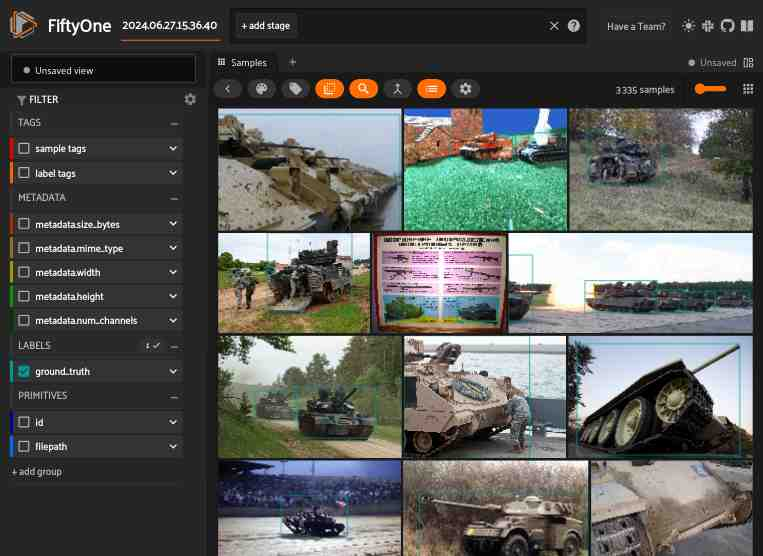

In [13]:
session.show()

### Train a YoloV8 model

We can now train a YoloV8 base model on our exported dataset. We use the `yolov8n.pt` (nano) model, which is the smallest, but larger models are available from ultralytics. Simply replace `yolov8n.pt` with the [right model](https://docs.ultralytics.com/models/yolov8/#key-features).

In [14]:
from adomvi.yolo.yolo import train

results_train = train("yolov8m.pt", data=dataset_dir / "dataset.yaml", epochs=80, batch=64, device=1)

#Load the path of the training model results
results_train_dir = Path(results_train.save_dir)

New https://pypi.org/project/ultralytics/8.2.45 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.2.38 🚀 Python-3.10.14 torch-2.3.1+cu121 CUDA:1 (NVIDIA RTX A6000, 48677MiB)
engine/trainer: task=detect, mode=train, model=yolov8m.pt, data=dataset/dataset.yaml, epochs=80, time=None, patience=100, batch=64, imgsz=640, save=True, save_period=-1, cache=False, device=1, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_fra

train: Scanning /home/ukemkata/workspace/adomvi2/notebooks/dataset/labels/train.cache... 2668 images, 41 backgrounds, 0 corrupt: 100%|██████████| 2668/2668 [00:00<?, ?it/s]
val: Scanning /home/ukemkata/workspace/adomvi2/notebooks/dataset/labels/val.cache... 334 images, 2 backgrounds, 0 corrupt: 100%|██████████| 334/334 [00:00<?, ?it/s]


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train
Starting training for 80 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/80      25.4G      1.001      2.413       1.44        133        640: 100%|██████████| 42/42 [00:45<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.33s/it]

                   all        334        432       0.19      0.218      0.158     0.0852



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/80      25.7G      1.112      1.501      1.522        157        640: 100%|██████████| 42/42 [00:43<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.29s/it]

                   all        334        432    0.00146      0.133   0.000839   0.000265



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/80      25.2G       1.24      1.624      1.611        138        640: 100%|██████████| 42/42 [00:44<00:00,  1.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:04<00:00,  1.49s/it]

                   all        334        432      0.276     0.0812    0.00374    0.00148



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/80      25.7G       1.24      1.583      1.613        142        640: 100%|██████████| 42/42 [00:43<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.26s/it]

                   all        334        432      0.381      0.368       0.11     0.0607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/80      25.6G      1.167      1.515      1.547        128        640: 100%|██████████| 42/42 [00:44<00:00,  1.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:04<00:00,  1.44s/it]

                   all        334        432      0.461      0.405       0.22      0.114



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/80      25.3G      1.145      1.447      1.539        131        640: 100%|██████████| 42/42 [00:42<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:04<00:00,  1.65s/it]

                   all        334        432      0.601      0.418      0.381      0.232



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/80      25.6G      1.089      1.387      1.489        140        640: 100%|██████████| 42/42 [00:43<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.21s/it]

                   all        334        432      0.656      0.395      0.377      0.249



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/80      25.2G       1.04      1.332       1.46        128        640: 100%|██████████| 42/42 [00:43<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.25s/it]

                   all        334        432      0.623      0.495      0.404       0.26



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/80      25.6G      1.031      1.298      1.452        128        640: 100%|██████████| 42/42 [00:42<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:04<00:00,  1.39s/it]

                   all        334        432      0.683      0.317      0.386      0.207



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/80      25.6G      1.012      1.264      1.439        139        640: 100%|██████████| 42/42 [00:43<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:04<00:00,  1.51s/it]

                   all        334        432      0.678      0.464       0.48      0.353



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/80      25.6G     0.9942      1.222      1.424        131        640: 100%|██████████| 42/42 [00:43<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.19s/it]

                   all        334        432      0.679      0.509      0.494      0.365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/80      25.6G     0.9668       1.19      1.398        126        640: 100%|██████████| 42/42 [00:43<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.22s/it]

                   all        334        432      0.723      0.484      0.515      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/80      25.6G     0.9503      1.163      1.385        134        640: 100%|██████████| 42/42 [00:43<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.21s/it]

                   all        334        432      0.725      0.472       0.52       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/80      25.6G     0.9321      1.126      1.376        139        640: 100%|██████████| 42/42 [00:41<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.32s/it]

                   all        334        432      0.749      0.501      0.578      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/80      25.6G     0.9063      1.115      1.353        134        640: 100%|██████████| 42/42 [00:38<00:00,  1.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.03it/s]

                   all        334        432      0.696      0.538      0.555      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/80      25.6G     0.8994      1.065      1.356        162        640: 100%|██████████| 42/42 [00:39<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.31s/it]

                   all        334        432      0.859      0.518      0.689      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/80      25.2G     0.8924      1.052      1.339        119        640: 100%|██████████| 42/42 [00:38<00:00,  1.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.17s/it]

                   all        334        432       0.43      0.485      0.485       0.37



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/80      25.3G       0.89      1.064      1.347        137        640: 100%|██████████| 42/42 [00:38<00:00,  1.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.20s/it]

                   all        334        432      0.489       0.59      0.585      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/80      25.6G     0.8531      1.027      1.318        136        640: 100%|██████████| 42/42 [00:39<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:04<00:00,  1.41s/it]

                   all        334        432      0.774      0.481      0.537      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/80      25.2G     0.8281     0.9809      1.302        131        640: 100%|██████████| 42/42 [00:43<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:04<00:00,  1.47s/it]

                   all        334        432      0.671      0.599      0.626      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/80      25.6G     0.8406     0.9796      1.305        141        640: 100%|██████████| 42/42 [00:43<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:04<00:00,  1.34s/it]

                   all        334        432      0.684      0.617      0.655      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/80      25.2G     0.8198     0.9634      1.296        156        640: 100%|██████████| 42/42 [00:43<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.22s/it]

                   all        334        432      0.842      0.555      0.638      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/80      25.3G     0.8227     0.9361      1.296        139        640: 100%|██████████| 42/42 [00:43<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:04<00:00,  1.51s/it]

                   all        334        432      0.519      0.572      0.584      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/80      25.6G      0.808     0.9209      1.281        156        640: 100%|██████████| 42/42 [00:43<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.24s/it]

                   all        334        432      0.623      0.624      0.673       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/80      25.6G      0.814     0.9135      1.283        142        640: 100%|██████████| 42/42 [00:43<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:04<00:00,  1.35s/it]

                   all        334        432      0.517      0.656      0.629      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/80      25.6G     0.7928     0.9155      1.267        146        640: 100%|██████████| 42/42 [00:43<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.25s/it]

                   all        334        432      0.607      0.637      0.682      0.546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/80      25.7G     0.7942     0.8847      1.267        142        640: 100%|██████████| 42/42 [00:42<00:00,  1.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.26s/it]

                   all        334        432      0.508       0.59      0.551      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/80      25.7G     0.7694     0.8698      1.252        139        640: 100%|██████████| 42/42 [00:43<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.23s/it]

                   all        334        432      0.686      0.602      0.702      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/80      25.6G     0.7641     0.8232      1.245        138        640: 100%|██████████| 42/42 [00:42<00:00,  1.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:04<00:00,  1.65s/it]

                   all        334        432      0.552      0.722      0.662      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/80      25.2G     0.7574     0.8422      1.247        141        640: 100%|██████████| 42/42 [00:43<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:04<00:00,  1.46s/it]

                   all        334        432      0.723      0.695      0.769      0.596



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/80      25.2G     0.7497     0.8215      1.231        166        640: 100%|██████████| 42/42 [00:42<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.14s/it]

                   all        334        432      0.665      0.616       0.69      0.561



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/80      25.2G     0.7464     0.8113      1.237        130        640: 100%|██████████| 42/42 [00:42<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.16s/it]

                   all        334        432       0.78      0.616      0.725      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/80      25.3G     0.7399      0.792      1.222        128        640: 100%|██████████| 42/42 [00:43<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.81it/s]

                   all        334        432       0.85       0.65      0.745      0.622



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/80      25.2G     0.7288     0.7754      1.223        167        640: 100%|██████████| 42/42 [00:38<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.23s/it]

                   all        334        432      0.755      0.752       0.83      0.658



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/80      25.2G     0.7184     0.7769      1.221        122        640: 100%|██████████| 42/42 [00:38<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.21s/it]

                   all        334        432      0.688      0.642      0.725        0.6



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/80      25.2G     0.7248     0.7554      1.218        136        640: 100%|██████████| 42/42 [00:38<00:00,  1.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.16s/it]

                   all        334        432      0.736      0.693      0.759       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/80      25.2G     0.7077     0.7454      1.206        124        640: 100%|██████████| 42/42 [00:38<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.24s/it]

                   all        334        432      0.749      0.644      0.744      0.615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/80      25.2G     0.7049      0.723      1.202        162        640: 100%|██████████| 42/42 [00:38<00:00,  1.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.25s/it]

                   all        334        432      0.821      0.678      0.812      0.681



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/80      25.3G     0.7008     0.7055      1.201        139        640: 100%|██████████| 42/42 [00:41<00:00,  1.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:05<00:00,  1.76s/it]

                   all        334        432      0.664      0.831      0.806      0.665



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/80      25.2G     0.6797     0.7102      1.182        136        640: 100%|██████████| 42/42 [00:43<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:04<00:00,  1.40s/it]

                   all        334        432      0.687      0.807      0.795       0.66



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/80      25.2G      0.678     0.6886      1.183        142        640: 100%|██████████| 42/42 [00:43<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.33s/it]

                   all        334        432      0.714      0.783      0.795       0.66



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/80      25.2G      0.666     0.6736      1.179        160        640: 100%|██████████| 42/42 [00:43<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.32s/it]

                   all        334        432      0.698      0.828      0.842      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/80      25.2G     0.6613     0.6664       1.17        130        640: 100%|██████████| 42/42 [00:43<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.22s/it]

                   all        334        432      0.785      0.777      0.821      0.678



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/80      25.3G     0.6574     0.6472      1.167        144        640: 100%|██████████| 42/42 [00:44<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.22s/it]

                   all        334        432      0.753      0.651      0.773      0.644



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/80      25.3G      0.657     0.6507      1.173        135        640: 100%|██████████| 42/42 [00:43<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.25s/it]

                   all        334        432      0.731      0.726      0.818      0.672



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/80      25.2G     0.6539     0.6417      1.166        137        640: 100%|██████████| 42/42 [00:43<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.27s/it]

                   all        334        432       0.85      0.732      0.828      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/80      25.8G     0.6487     0.6361      1.164        118        640: 100%|██████████| 42/42 [00:42<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:04<00:00,  1.44s/it]

                   all        334        432      0.832      0.759      0.833      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/80      25.7G     0.6438     0.6339      1.163        156        640: 100%|██████████| 42/42 [00:43<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.21s/it]

                   all        334        432       0.75      0.791      0.856      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/80      25.8G     0.6364     0.6126      1.151        139        640: 100%|██████████| 42/42 [00:43<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.20s/it]

                   all        334        432      0.781       0.68      0.775      0.672



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/80      25.2G      0.625     0.6171      1.144        157        640: 100%|██████████| 42/42 [00:44<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.21s/it]

                   all        334        432      0.756      0.721      0.814      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      51/80      25.2G     0.6111        0.6      1.141        131        640: 100%|██████████| 42/42 [00:43<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:04<00:00,  1.33s/it]

                   all        334        432      0.817      0.713      0.762      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      52/80      25.6G     0.6058     0.5747      1.133        145        640: 100%|██████████| 42/42 [00:44<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.18s/it]

                   all        334        432       0.83      0.727      0.775       0.66



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      53/80        26G     0.6187     0.5846      1.147        109        640: 100%|██████████| 42/42 [00:39<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.03it/s]

                   all        334        432      0.801      0.653      0.774      0.646



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      54/80      25.2G     0.6113     0.5783      1.136        144        640: 100%|██████████| 42/42 [00:39<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.05it/s]

                   all        334        432      0.798      0.674       0.82      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      55/80      25.6G     0.5868     0.5595      1.123        141        640: 100%|██████████| 42/42 [00:39<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.03it/s]

                   all        334        432      0.722      0.703      0.835        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      56/80      25.3G     0.5922      0.551      1.121        145        640: 100%|██████████| 42/42 [00:40<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.11s/it]

                   all        334        432      0.764      0.758      0.817      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      57/80      25.6G     0.5876     0.5455      1.121        152        640: 100%|██████████| 42/42 [00:39<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.05s/it]

                   all        334        432      0.747      0.699        0.8       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      58/80      25.2G     0.5754     0.5274      1.111        148        640: 100%|██████████| 42/42 [00:41<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.17s/it]

                   all        334        432      0.708      0.886      0.889      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      59/80      25.6G     0.5731     0.5374       1.11        180        640: 100%|██████████| 42/42 [00:43<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.17s/it]

                   all        334        432      0.847      0.716      0.862       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      60/80      25.2G     0.5714     0.5217      1.112        156        640: 100%|██████████| 42/42 [00:43<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:05<00:00,  1.76s/it]

                   all        334        432      0.806      0.786      0.822      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      61/80      25.3G     0.5598      0.511      1.102        160        640: 100%|██████████| 42/42 [00:43<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.20s/it]

                   all        334        432      0.787      0.851       0.86      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      62/80      25.7G     0.5538      0.499      1.094        135        640: 100%|██████████| 42/42 [00:43<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:04<00:00,  1.63s/it]

                   all        334        432      0.767      0.813      0.879      0.744



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      63/80      25.7G     0.5566     0.5065      1.102        151        640: 100%|██████████| 42/42 [00:44<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:04<00:00,  1.36s/it]

                   all        334        432      0.796      0.762      0.872      0.748



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      64/80      25.7G     0.5493     0.4996      1.094        134        640: 100%|██████████| 42/42 [00:44<00:00,  1.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:04<00:00,  1.36s/it]

                   all        334        432      0.849       0.69      0.821      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      65/80      25.2G     0.5506     0.5057      1.098        172        640: 100%|██████████| 42/42 [00:44<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.28s/it]

                   all        334        432      0.857      0.837      0.867      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      66/80      25.6G     0.5296     0.4786      1.075        171        640: 100%|██████████| 42/42 [00:43<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:04<00:00,  1.41s/it]

                   all        334        432      0.807      0.766      0.829      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      67/80      25.2G     0.5267     0.4703      1.074        163        640: 100%|██████████| 42/42 [00:43<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:04<00:00,  1.43s/it]

                   all        334        432       0.82      0.775      0.862      0.747



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      68/80      25.6G     0.5267     0.4748      1.083        140        640: 100%|██████████| 42/42 [00:43<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:04<00:00,  1.56s/it]

                   all        334        432      0.938      0.801      0.874      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      69/80      25.6G     0.5183     0.4596      1.073        155        640: 100%|██████████| 42/42 [00:44<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.26s/it]

                   all        334        432      0.823      0.751      0.802      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      70/80      25.6G     0.5059      0.449      1.072        137        640: 100%|██████████| 42/42 [00:44<00:00,  1.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:04<00:00,  1.42s/it]

                   all        334        432      0.761       0.76      0.872      0.745


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      71/80      25.6G     0.4029     0.3247      1.001         63        640: 100%|██████████| 42/42 [00:41<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.05s/it]

                   all        334        432      0.804      0.797      0.863      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      72/80      25.3G     0.3865     0.2917     0.9835         57        640: 100%|██████████| 42/42 [00:38<00:00,  1.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.20s/it]

                   all        334        432      0.888      0.769      0.888      0.759



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      73/80      25.6G     0.3741     0.2776     0.9628         55        640: 100%|██████████| 42/42 [00:38<00:00,  1.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.16s/it]

                   all        334        432      0.892       0.76       0.89      0.758



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      74/80      25.2G     0.3699     0.2718     0.9688         62        640: 100%|██████████| 42/42 [00:39<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.28s/it]

                   all        334        432      0.935      0.762      0.907      0.771



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      75/80      25.2G     0.3602     0.2675     0.9641         61        640: 100%|██████████| 42/42 [00:38<00:00,  1.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.28s/it]

                   all        334        432      0.855      0.783       0.86      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      76/80      25.3G     0.3561     0.2635     0.9644         58        640: 100%|██████████| 42/42 [00:38<00:00,  1.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.31s/it]

                   all        334        432       0.82      0.824      0.859      0.744



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      77/80      25.7G     0.3432     0.2487     0.9495         45        640: 100%|██████████| 42/42 [00:43<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.22s/it]

                   all        334        432      0.821      0.822      0.878      0.754



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      78/80      25.2G     0.3394     0.2421     0.9495         49        640: 100%|██████████| 42/42 [00:43<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:04<00:00,  1.41s/it]

                   all        334        432      0.828      0.834      0.894      0.765



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      79/80      25.6G     0.3367      0.236     0.9429         60        640: 100%|██████████| 42/42 [00:43<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.24s/it]

                   all        334        432      0.895      0.774      0.902      0.761



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      80/80      25.2G     0.3276     0.2343      0.941         53        640: 100%|██████████| 42/42 [00:43<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:04<00:00,  1.40s/it]

                   all        334        432      0.934      0.695      0.879      0.762



80 epochs completed in 1.056 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 52.0MB
Optimizer stripped from runs/detect/train/weights/best.pt, 52.0MB

Validating runs/detect/train/weights/best.pt...
Ultralytics YOLOv8.2.38 🚀 Python-3.10.14 torch-2.3.1+cu121 CUDA:1 (NVIDIA RTX A6000, 48677MiB)
Model summary (fused): 218 layers, 25842076 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:04<00:00,  1.42s/it]


                   all        334        432      0.936      0.762      0.906      0.777
                   AFV        255        351      0.937      0.676      0.888      0.673
                   APC         45         49      0.932      0.845      0.913      0.832
                   MEV          6          6      0.905      0.833      0.899      0.749
                   LAV         26         26      0.971      0.692      0.922      0.855
Speed: 0.3ms preprocess, 4.5ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to runs/detect/train


### Use the fine-tuned model to predict detections

Once our model is trained, we can simply use it to predict detections on our test dataset. Simply pass the path to the best model weights and the directory containing the test images to the `predict` function.

In [15]:
from adomvi.yolo.yolo import predict

best_model = Path() / results_train_dir / "weights/best.pt"
results_predict = predict(best_model, source=dataset_dir / "images/test")

# Load the path of the prediction model results
results_predict_dir = Path(results_predict[0].save_dir)


image 1/333 /home/ukemkata/workspace/adomvi2/notebooks/dataset/images/test/01daecbf2075b822.jpg: 480x640 3 AFVs, 116.3ms
image 2/333 /home/ukemkata/workspace/adomvi2/notebooks/dataset/images/test/02766a4a2a22632b.jpg: 640x448 1 AFV, 113.4ms
image 3/333 /home/ukemkata/workspace/adomvi2/notebooks/dataset/images/test/030eab769f338ba7.jpg: 352x640 2 AFVs, 110.6ms
image 4/333 /home/ukemkata/workspace/adomvi2/notebooks/dataset/images/test/03aa6bc2d62cc59a.jpg: 448x640 1 AFV, 107.4ms
image 5/333 /home/ukemkata/workspace/adomvi2/notebooks/dataset/images/test/03bdfb19-c4b2-4d1f-af9f-091baa23d5d9.JPEG: 448x640 1 MEV, 11.8ms
image 6/333 /home/ukemkata/workspace/adomvi2/notebooks/dataset/images/test/03dd97c389d284a9.jpg: 320x640 1 AFV, 103.9ms
image 7/333 /home/ukemkata/workspace/adomvi2/notebooks/dataset/images/test/044a3e7c7b006202.jpg: 640x640 1 AFV, 19.5ms
image 8/333 /home/ukemkata/workspace/adomvi2/notebooks/dataset/images/test/0456e7f65df9f603.jpg: 384x640 1 AFV, 106.6ms
image 9/333 /home/

In [16]:
import pickle

# Save the best_model variable to a file
with open('best_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

### Evaluate model predictions

We can first evaluate our model by loading the predictions in a Fiftyone dataset view of our test data. We select the images tagged as part of the test set in our dataset.

In [17]:
# The test split of the dataset
test_view = dataset.match_tags("test")

Then we can load the model predictions as fields of the images in our test view.

In [18]:
from adomvi.yolo.utils import add_yolo_detections

prediction_field = "yolov8"
predictions_dir = Path() / results_predict_dir / "labels"
add_yolo_detections(test_view, prediction_field=prediction_field, predictions_dir=predictions_dir, class_list=["AFV", "APC", "MEV", "LAV"])

Now we can visualize these YOLOv8 model predictions on the samples in our dataset in the FiftyOne app:

In [19]:
session.show()

Finally, we can evaluate our model's predictions and print the mAP.

In [20]:
detection_results = test_view.evaluate_detections(
    prediction_field, 
    eval_key="eval",
    compute_mAP=True,
    gt_field="ground_truth",
)

Evaluating detections...
 100% |█████████████████| 333/333 [833.2ms elapsed, 0s remaining, 399.7 samples/s]      
Performing IoU sweep...
 100% |█████████████████| 333/333 [960.7ms elapsed, 0s remaining, 359.6 samples/s]      


In [21]:
mAP = detection_results.mAP()
print(f"mAP = {mAP}")

mAP = 0.6339064214614244


In [22]:
detection_results.print_report()

              precision    recall  f1-score   support

         AFV       0.76      0.85      0.80       343
         APC       0.69      0.72      0.70        64
         LAV       0.55      0.72      0.62        25
         MEV       0.62      0.71      0.67         7

   micro avg       0.74      0.82      0.78       439
   macro avg       0.65      0.75      0.70       439
weighted avg       0.74      0.82      0.78       439

